In [23]:
import os
import sys
import time
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import linregress
from sklearn.neighbors import KernelDensity
from datetime import date, datetime, timedelta

In [24]:
## Read data

# Variables - change these as needed
job_id = '02Feb2021'
week_minus_one = '24-Jan-2021'

# Fixed variables
dc_location_allowed = {'GB40','GB47','GB73'}
test_weeks = 8
horizon_weeks = 12
data_path = '/Users/sandeepdhankhar/OneDrive - Aera Technology/8 Project Mars/Data/'

dc_forecast = pd.read_csv(os.path.join(data_path,job_id,'input','dc_forecast.csv'), dtype = {'dfu':str,'location':str})
dc_actuals = pd.read_csv(os.path.join(data_path,job_id,'input','dc_actuals.csv'), dtype = {'dfu':str,'location':str})
prodn_actuals = pd.read_csv(os.path.join(data_path,job_id,'input','production_actuals.csv'), dtype = {'dfu':str,'location':str})    


## Pre-processing

In [25]:
## Functions
def get_year_week(dateSeries):
    yearSeries = dateSeries.apply(lambda x: x.strftime("%Y")).astype(str)
    weekSeries = dateSeries.apply(lambda x: x.strftime("%U")).astype(str)  #week starting Sunday - same as Mars
    yearWeek = yearSeries + weekSeries
    return yearWeek.astype(int)

def get_missing_snapshots(single_grain,dfu_name,location_name,suffix):
    # Snapshots present
    snapshotsPresent = set(single_grain['Week_Start_Date'])
    numOfSnapshots = len(snapshotsPresent)
    firstSnapshotDate = min(snapshotsPresent)
    lastSnapshotDate = max(snapshotsPresent)
    # Find missing snapshots date
    all_snapshots = set(pd.date_range(start = firstSnapshotDate, end = lastSnapshotDate, freq = 'W'))
    missingSnapshots = all_snapshots - snapshotsPresent
    missingSnapshots = [x.strftime('%Y-%m-%d') for x in missingSnapshots]
    # Consolidate
    summary = {'dfu':dfu_name,'location':location_name,'NumOfSnapshot'+suffix:numOfSnapshots,
               'FirstSnapshot'+suffix:firstSnapshotDate.strftime('%Y-%m-%d'),
               'LastSnapshot'+suffix:lastSnapshotDate.strftime('%Y-%m-%d'),
               'MissingSnapshot'+suffix:missingSnapshots,
               'NumberOfSnapshotsMissing'+suffix:len(missingSnapshots)
               }
    return summary

def get_snapshot_summary(data,group,suffix):
    grain_summary = []
    grain_groups = data.groupby(group)
    for name,group in grain_groups:
        grain_summary.append(get_missing_snapshots(group,name[0],name[1],suffix))
    data_summary = pd.DataFrame(grain_summary)    
    #data_summary = data_summary[data_summary['NumberOfSnapshotsMissing'] != 0]
    return data_summary

def insert_missing_time_periods_prodn(prodn):
    # looping over each grain
    grain_groups = prodn.groupby(['dfu','location','line'])
    grain_complete = []
    for name,singleGrain in grain_groups:
        # Re-index - add all time periods between start and end date
        singleGrain = singleGrain.set_index('Week_Start_Date')
        idx = pd.date_range(start = min(singleGrain.index),end = max(singleGrain.index),freq='W')
        singleGrain = singleGrain.reindex(list(idx))
        # fill na
        singleGrain[['dfu','location','line']] = singleGrain[['dfu','location','line']].fillna(method='ffill')
        singleGrain[['actual_production_in_ea','scheduled_production_in_ea']] = singleGrain[['actual_production_in_ea','scheduled_production_in_ea']].fillna(0)
        singleGrain[['csl','ats']] = singleGrain[['csl','ats']].fillna(100)
        grain_complete.append(singleGrain)
    # re-arrange cols
    prodn_complete = pd.concat(grain_complete).reset_index()
    return prodn_complete[['dfu','location','line','Week_Start_Date','actual_production_in_ea','scheduled_production_in_ea','csl','ats']]

def mad_outlier_treatment(data,col):
    d = data.copy()
    # 2MAD method
    d['ShiftedQty'] = d[col].shift(1)
    d['RollingMedian'] = d['ShiftedQty'].transform(lambda x: x.rolling(6, 1).median())
    d['AbsDeviation'] = abs(d['RollingMedian'] - d[col])
    d['MAD'] = d['AbsDeviation'].median()
    d['OutlierFlag_2MAD'] = [1 if dev > 2*mad else 0 for dev,mad in zip(d['AbsDeviation'],d['MAD'])]
    d[col+'_MAD'] = [z if x==1 else y for x,y,z in zip(d['OutlierFlag_2MAD'],d[col],d['RollingMedian'])]
    d = d.drop(['ShiftedQty','RollingMedian','AbsDeviation','MAD','OutlierFlag_2MAD'],axis=1) 
    return d

def iqr_outlier_treatment(data,col):
    d = data.copy()
    q1,q3 = np.percentile(d[col],[25,75])
    IQR = q3-q1
    lower_bound = q1 - (IQR*1.5)
    upper_bound = q3 + (IQR*1.5)
    d[col+'_IQR'] = d[col]
    d[col+'_IQR'] = [lower_bound if x < lower_bound else x for x in d[col]]
    d[col+'_IQR'] = [upper_bound if x > upper_bound else x for x in d[col]]
    return d

def get_ats_csl_correlation(data,ats_col):
    ats = data[ats_col]
    csl = data['csl']
    csl = csl[~ats.isin([np.nan, np.inf, -np.inf])] # Remove unwanted values
    ats = ats[~ats.isin([np.nan, np.inf, -np.inf])] # Remove unwanted values
    out = linregress(ats,csl)
    return pd.DataFrame({'Correlation':[out.rvalue],'P-Value':[out.pvalue],'NumOfPoints':[len(ats)],'Coefficient':[out.slope]})

def recalculate_ats(row):
    if (row['actual_production_in_ea'] == 0) & (row['scheduled_production_in_ea'] == 0):
        return 100
    elif row['scheduled_production_in_ea'] == 0:
        return 0
    else:
        return row['actual_production_in_ea']*100/row['scheduled_production_in_ea']
    
def cap_ats(ats):
    if ats > 120:
        return 120
    elif ats < 0:
        return 0
    else:
        return ats
    
def get_max_density_outcome(series):
    #sns.distplot(data, hist=False)
    #plt.show()
    X = series.to_numpy().reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X)
    X_plot = np.linspace(-100, 300, 1000)[:, np.newaxis]    
    log_dens = np.exp(kde.score_samples(X_plot))
    max_density_val = X_plot[np.argmax(log_dens),0]
    return max_density_val

def train_linear_model(data,y,x):
    slope, intercept, r_value, p_value, std_err = linregress(data[x], data[y])
    return pd.DataFrame({'slope':[slope], 'intercept':[intercept]})

In [26]:
# Column rename
dc_forecast.rename(columns = {'forecast_week':'Week_Start_Date'}, inplace = True)
dc_actuals.rename(columns = {'week':'Week_Start_Date'}, inplace = True)
prodn_actuals.rename(columns = {'date':'Week_Start_Date'}, inplace = True)

# Convert to datetime
dc_forecast['Week_Start_Date'] = pd.to_datetime(dc_forecast['Week_Start_Date'],format='%Y-%m-%d')
dc_actuals['Week_Start_Date'] = pd.to_datetime(dc_actuals['Week_Start_Date'],format='%Y-%m-%d')
prodn_actuals['Week_Start_Date'] = pd.to_datetime(prodn_actuals['Week_Start_Date'],format='%Y-%m-%d')

# Filter unknown data
dc_forecast = dc_forecast[~((dc_forecast['dfu'] == "Not Set") | (dc_forecast['location'] == "not_available"))]
dc_actuals = dc_actuals[~((dc_actuals['dfu'] == "Not Set") | (dc_actuals['location'] == "not_available"))]
prodn_actuals = prodn_actuals[~((prodn_actuals['dfu'] == "Not Set") | (prodn_actuals['location'] == "not_available") | (prodn_actuals['line'] == "Not Set"))]
dc_actuals = dc_actuals[dc_actuals['location'].isin(dc_location_allowed)]

# Keep historical data
week_minus_one = datetime.strptime(week_minus_one,'%d-%b-%Y')
dc_forecast = dc_forecast[dc_forecast['Week_Start_Date'] <= week_minus_one]
dc_actuals = dc_actuals[dc_actuals['Week_Start_Date'] <= week_minus_one]
prodn_actuals = prodn_actuals[prodn_actuals['Week_Start_Date'] <= week_minus_one]

# Get top DFU's - 90% portfolio share in past 1 year
date_now = datetime.now()
date_year_ago = date_now - timedelta(days = 365)
cutOff = 90
lastOneYearActual = dc_actuals.loc[dc_actuals['Week_Start_Date'] >= date_year_ago]
aggLastOneYear = lastOneYearActual.groupby(['dfu']).agg(PercentageShare=('actuals',lambda x: round(x.sum()*100/sum(lastOneYearActual['actuals']),2))).reset_index()
aggLastOneYear = aggLastOneYear.sort_values(by=['PercentageShare'], ascending=False).reset_index(drop=True)
aggLastOneYear['CumulativeShare'] = aggLastOneYear['PercentageShare'].cumsum()    
top_dfu = list(aggLastOneYear['dfu'][aggLastOneYear['CumulativeShare'] <=cutOff])

# Keep top DFU's
dc_forecast  = dc_forecast[dc_forecast['dfu'].isin(top_dfu)]
dc_actuals  = dc_actuals[dc_actuals['dfu'].isin(top_dfu)]
prodn_actuals  = prodn_actuals[prodn_actuals['dfu'].isin(top_dfu)]

In [27]:
# Holdout and test period
last_date = week_minus_one
holdout_date = last_date - timedelta(days=7*test_weeks) #8 weeks test data
horizon_date = last_date + timedelta(days=7*horizon_weeks) #12 weeks in future
date_series = pd.Series([holdout_date,last_date,horizon_date])
cortex_ip = pd.DataFrame({'Type': ['HoldOut','LastDate','HorizonDate'],
                               'YearWeek': list(get_year_week(date_series)),
                               'Date':[holdout_date,last_date,horizon_date]})
cortex_ip

Type  YearWeek       Date
0      HoldOut    202048 2020-11-29
1     LastDate    202104 2021-01-24
2  HorizonDate    202116 2021-04-18

In [28]:
# Missing snapshot summary
prodn_summary = get_snapshot_summary(prodn_actuals,['dfu','location'],'_prodn')
prodn_summary = prodn_summary[['dfu','location','FirstSnapshot_prodn','LastSnapshot_prodn','NumberOfSnapshotsMissing_prodn']]
prodn_summary.columns = ['DFU','Location','First_Snapshot_Production','Last_Snapshot_Production','Num_of_Missing_Snapshots_Production']
prodn_summary = prodn_summary.sort_values('Num_of_Missing_Snapshots_Production',ascending = False)
prodn_summary.head()

DFU Location First_Snapshot_Production Last_Snapshot_Production  \
0   104383     FR08                2019-09-08               2021-01-24   
57  361874     FR08                2019-09-08               2021-01-24   
83  393104     PL01                2019-09-08               2021-01-24   
82  393080     PL01                2019-09-08               2021-01-03   
81  392086     RU09                2019-09-08               2021-01-24   

    Num_of_Missing_Snapshots_Production  
0                                     0  
57                                    0  
83                                    0  
82                                    0  
81                                    0

In [29]:
# Fill missing time-periods
prodn_actuals_complete = insert_missing_time_periods_prodn(prodn_actuals)
prodn_actuals_complete['ats'] = prodn_actuals_complete.apply(recalculate_ats,axis=1)
# Remove data before 13th Oct 2019 => incorrect data
prodn_actuals_complete = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] >= datetime(2019, 10, 13)]

# Remove data before 1st Jan 2020 => ats,csl missing in most of the grains
prodn_actuals_complete = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] >= datetime(2020, 1, 1)]

# Calculate lag1 and lag2
prodn_actuals_complete['ats_lag1'] = prodn_actuals_complete.groupby(['dfu','location'])['ats'].shift(1)
prodn_actuals_complete['ats_lag2'] = prodn_actuals_complete.groupby(['dfu','location'])['ats'].shift(2)
prodn_actuals_complete.head()


dfu location        line Week_Start_Date  actual_production_in_ea  \
17  104383     FR08  HAG CRISPY      2020-01-05                  13850.0   
18  104383     FR08  HAG CRISPY      2020-01-12                  34239.0   
19  104383     FR08  HAG CRISPY      2020-01-19                  30611.0   
20  104383     FR08  HAG CRISPY      2020-01-26                  30156.0   
21  104383     FR08  HAG CRISPY      2020-02-02                  27245.0   

    scheduled_production_in_ea    csl         ats    ats_lag1    ats_lag2  
17                     13000.0   0.00  106.538462         NaN         NaN  
18                     33899.0  17.20  101.002979  106.538462         NaN  
19                     23800.0  63.57  128.617647  101.002979  106.538462  
20                     40161.0   5.04   75.087772  128.617647  101.002979  
21                     18116.0  30.07  150.391919   75.087772  128.617647

## DFU Level Analysis

In [30]:
# Disribution of data points
num_of_data_pts_per_grain = prodn_actuals_complete.groupby(['dfu','location']).agg(Num_Of_Data_pts = ('dfu','count'))
print('Number of grains considered - {}'.format(len(num_of_data_pts_per_grain)))
sns.displot(num_of_data_pts_per_grain, x="Num_Of_Data_pts",kde=True)

Number of grains considered - 113


In [31]:
# Intermittency in ATS
prodn_actuals_complete['ats_is_zero'] = prodn_actuals_complete['ats'].apply(lambda x: 1 if x==0 else 0)
intermittency = prodn_actuals_complete.groupby(['dfu','location']).agg(intermittency = ('ats_is_zero','mean'))
sns.displot(intermittency, x="intermittency")

In [32]:
#intermittency.to_csv(os.path.join(data_path,job_id,'exp','intermittency.csv'),index=False)

In [33]:
#intermittency.sort_values('intermittency')
#prodn_actuals_complete.groupby(['dfu','location']).get_group(('361970','NL01'))

In [34]:
# Line chart ATS
prodn_grains = prodn_actuals_complete.groupby(['dfu','location'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#fig.suptitle('ATS trend over time for Different Grains')

i=0; j=0
for grain in num_of_data_pts_per_grain.index[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_grains.get_group(grain), x="Week_Start_Date", y="ats")
    ax.set(ylim=(0, 250))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    j+=1; 
    if j > 2:j=0;i=1

('104383', 'FR08')
('105230', 'NL01')
('106470', 'GB18')
('111010', 'PL01')
('130828', 'PL01')
('176429', 'PL01')


In [35]:
# Correlation Analysis
'''
To validate - CSL values
'''

ats_csl_corr_lag0 = prodn_actuals_complete.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats').reset_index().sort_values('P-Value')
ats_csl_corr_lag1 = prodn_actuals_complete.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats_lag1').reset_index().sort_values('P-Value')
ats_csl_corr_lag2 = prodn_actuals_complete.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats_lag2').reset_index().sort_values('P-Value')

#prodn_actuals_complete.to_csv(os.path.join(data_path,job_id,'exp','prodn_actuals_complete.csv'),index=False)
#ats_csl_corr_lag2.to_csv(os.path.join(data_path,job_id,'exp','ats_csl_corr_lag2.csv'),index=False)


In [36]:
# Examples where correlation is significant
lag2_significant = ats_csl_corr_lag2[ats_csl_corr_lag2['Correlation'] >= 0]
lag2_significant = lag2_significant[lag2_significant['P-Value']< 0.05]
print('Number of grains with signifiant correlations at lag2 - {}'.format(lag2_significant.shape[0]))

lag1_significant = ats_csl_corr_lag1[ats_csl_corr_lag1['Correlation'] >= 0]
lag1_significant = lag1_significant[lag1_significant['P-Value']< 0.05]
print('Number of grains with signifiant correlations at lag1 - {}'.format(lag1_significant.shape[0]))

lag0_significant = ats_csl_corr_lag0[ats_csl_corr_lag0['Correlation'] >= 0]
lag0_significant = lag0_significant[lag0_significant['P-Value']< 0.05]
print('Number of grains with signifiant correlations at lag0 - {}'.format(lag0_significant.shape[0]))


Number of grains with signifiant correlations at lag2 - 13
Number of grains with signifiant correlations at lag1 - 3
Number of grains with signifiant correlations at lag0 - 5


In [37]:
# When ATS is less than 100
prodn_temp = prodn_actuals_complete[prodn_actuals_complete['ats_lag2'] < 100]
ats_csl_corr_lag2_temp = prodn_temp.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats_lag2').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag2_temp[ats_csl_corr_lag2_temp['P-Value']< 0.05].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag2 - {}'.format(count))

prodn_temp = prodn_actuals_complete[prodn_actuals_complete['ats_lag1'] < 100]
ats_csl_corr_lag1_temp = prodn_temp.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats_lag1').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag1_temp[ats_csl_corr_lag1_temp['P-Value']< 0.05].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag1 - {}'.format(count))

prodn_temp = prodn_actuals_complete[prodn_actuals_complete['ats'] < 100]
ats_csl_corr_lag0_temp = prodn_temp.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag0_temp[ats_csl_corr_lag0_temp['P-Value']< 0.05].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag0 - {}'.format(count))


Number of grains with signifiant correlations when ATS < 100 at lag2 - 21
Number of grains with signifiant correlations when ATS < 100 at lag1 - 14
Number of grains with signifiant correlations when ATS < 100 at lag0 - 15


## DFU Level - ML Models

In [38]:
#0. Cap ATS and re-calculate scheduled quantity
prodn_actuals_complete['ats_capped'] = prodn_actuals_complete['ats'].apply(cap_ats)
prodn_actuals_complete['scheduled_production_in_ea'] = prodn_actuals_complete['actual_production_in_ea']*100/prodn_actuals_complete['ats_capped']
'''Column for accuracy metric => ats_capped'''


'Column for accuracy metric => ats_capped'

In [39]:
# Line chart ATS
prodn_grains = prodn_actuals_complete.groupby(['dfu','location'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#fig.suptitle('ATS trend over time for Different Grains')

i=0; j=0
for grain in num_of_data_pts_per_grain.index[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_grains.get_group(grain), x="Week_Start_Date", y="ats_capped")
    ax.set(ylim=(0, 250))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    j+=1; 
    if j > 2:j=0;i=1

('104383', 'FR08')
('105230', 'NL01')
('106470', 'GB18')
('111010', 'PL01')
('130828', 'PL01')
('176429', 'PL01')


In [40]:
## ML Pre-processing

#1. Most likely outcome
holdout_date = cortex_ip['Date'].iloc[0]
train = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] <= holdout_date]
test = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] > holdout_date]
print(test.shape)
accuracy_frame = test[['dfu','location','line','Week_Start_Date','scheduled_production_in_ea','ats_capped']]
most_likely_outcome = train.groupby(['dfu','location']).agg(Most_Probable_Outcome = ('ats_capped',get_max_density_outcome)).reset_index()
accuracy_frame = accuracy_frame.merge(most_likely_outcome,on=['dfu','location'])

#2. Regression outcome
linregress_coeff = train.groupby(['dfu','location']).apply(train_linear_model,y='ats_capped',x='scheduled_production_in_ea').reset_index()
accuracy_frame = accuracy_frame.merge(linregress_coeff,on=['dfu','location'])
accuracy_frame['linregress_outcome'] = (accuracy_frame['slope']*accuracy_frame['scheduled_production_in_ea']) + accuracy_frame['intercept']

#3. Mars prediction of 100
accuracy_frame['mars_outcome'] = 100

accuracy_frame.head()

(897, 12)


dfu location        line Week_Start_Date  scheduled_production_in_ea  \
0  104383     FR08  HAG CRISPY      2020-12-06                      9617.5   
1  104383     FR08  HAG CRISPY      2020-12-13                     28271.0   
2  104383     FR08  HAG CRISPY      2020-12-20                         0.0   
3  104383     FR08  HAG CRISPY      2020-12-27                         0.0   
4  104383     FR08  HAG CRISPY      2021-01-03                         inf   

   ats_capped  Most_Probable_Outcome  level_2  slope  intercept  \
0  120.000000              119.81982        0    NaN        NaN   
1  100.710976              119.81982        0    NaN        NaN   
2  100.000000              119.81982        0    NaN        NaN   
3  100.000000              119.81982        0    NaN        NaN   
4    0.000000              119.81982        0    NaN        NaN   

   linregress_outcome  mars_outcome  
0                 NaN           100  
1                 NaN           100  
2                 NaN           100  
3                 NaN           100  
4                 NaN           100

In [41]:
#4. Time series prediction

# Trend smoothening
prodn_actuals_complete = prodn_actuals_complete.groupby(['dfu','location']).apply(mad_outlier_treatment,'ats_capped').reset_index(drop=True)
prodn_actuals_complete = prodn_actuals_complete.groupby(['dfu','location']).apply(iqr_outlier_treatment,'ats_capped').reset_index(drop=True)

# Modified ATS time series
prodn_grains = prodn_actuals_complete.groupby(['dfu','location'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ATS trend over time for Different Grains')

i=0; j=0
for grain in num_of_data_pts_per_grain.index[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_grains.get_group(grain), x="Week_Start_Date", y="ats_capped_MAD")
    ax.set(ylim=(0, 250))
    j+=1; 
    if j > 2:j=0;i=1


('104383', 'FR08')
('105230', 'NL01')
('106470', 'GB18')
('111010', 'PL01')
('130828', 'PL01')
('176429', 'PL01')


In [42]:
def get_iso_yearweek(x):
    year = str(x.isocalendar()[0])
    week = str(x.isocalendar()[1])
    if len(week)==1:
        week = '0'+week
    return year+week

In [43]:
x = prodn_actuals_complete[['Week_Start_Date','dfu','location','ats_capped_MAD']]
x['YearWeek'] = x['Week_Start_Date'].apply(lambda x: get_iso_yearweek(x))
x.columns = ['DD_STARTDATE','DD_DFU','DD_LOCATION','CT_SALES_HISTORY_EACHES','YearWeek']
y = x[['DD_STARTDATE','YearWeek']].drop_duplicates()
#x.to_csv(os.path.join(data_path,job_id,'exp','cortex_ip_ats_dfu_location_level.csv'),index=False)

#x['Week_Start_Date'][2].isocalendar()

<ipython-input-43-b04eb9527279>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['YearWeek'] = x['Week_Start_Date'].apply(lambda x: get_iso_yearweek(x))


In [44]:
'''# Cortex forecasting result
cortex_ats_fcst = pd.read_csv('/Users/sandeepdhankhar/OneDrive - Aera Technology/8 Project Mars/Data/02Feb2021/exp/cortex_ats_dfu_loc_forecast.csv')
cortex_ats_fcst = cortex_ats_fcst[['Grain-1','Grain-2','Actual Date Value','Ranking Mode Forecast Qty']]
cortex_ats_fcst = cortex_ats_fcst[cortex_ats_fcst['Actual Date Value'].isin([202049,202050,202051,202052,202053,202101,202102,202103])]
cortex_ats_fcst['Grain-1'] = cortex_ats_fcst['Grain-1'].astype(str)
cortex_ats_fcst['Actual Date Value'] = cortex_ats_fcst['Actual Date Value'].astype(str)
cortex_ats_fcst = cortex_ats_fcst.merge(y,left_on='Actual Date Value',right_on='YearWeek')

dfu_ts_predn = cortex_ats_fcst[['Grain-1','Grain-2','DD_STARTDATE','Ranking Mode Forecast Qty']]
dfu_ts_predn.columns = ['dfu','location','Week_Start_Date','Time_series_outcome']

accuracy_frame = accuracy_frame.merge(dfu_ts_predn,on=['dfu','location','Week_Start_Date'])
'''

# 6MA time series prediction
holdout_date = cortex_ip['Date'].iloc[0]
train = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] <= holdout_date]
test = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] > holdout_date]

futurePeriods =  pd.date_range(start = cortex_ip['Date'].iloc[0] + timedelta(days=7), 
                               end = cortex_ip['Date'].iloc[1], freq='W').to_list()
predn = []

for name,group in train.groupby(['dfu','location']):
    data = list(group['ats_capped_MAD'])
    # fit model
    model = ARIMA(data, order=(0, 0, 6))
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(len(data), len(data)+len(futurePeriods) - 1)

    predn.append(pd.DataFrame({'dfu':name[0],
                               'location':name[1],
                               'Week_Start_Date':futurePeriods,
                               'Time_series_outcome':yhat}))
    
dfu_ts_predn = pd.concat(predn).reset_index(drop=True)

accuracy_frame = accuracy_frame.merge(dfu_ts_predn,on=['dfu','location','Week_Start_Date'])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarnin

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximu

In [45]:
dfu_ts_predn.head(2)

dfu location Week_Start_Date  Time_series_outcome
0  104383     FR08      2020-12-06           102.723180
1  104383     FR08      2020-12-13           102.327334

<AxesSubplot:xlabel='Min_col', ylabel='count'>

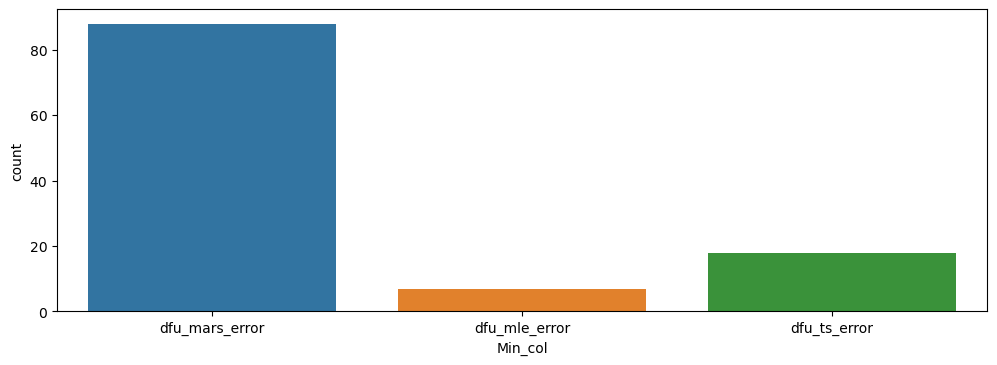

In [46]:
accuracy_frame_dfu = accuracy_frame.copy()

accuracy_frame_dfu['dfu_mle_error'] = abs(accuracy_frame_dfu['ats_capped'] - accuracy_frame_dfu['Most_Probable_Outcome'])
accuracy_frame_dfu['dfu_linreg_error'] = abs(accuracy_frame_dfu['ats_capped'] - accuracy_frame_dfu['linregress_outcome'])
accuracy_frame_dfu['dfu_mars_error'] = abs(accuracy_frame_dfu['ats_capped'] - accuracy_frame_dfu['mars_outcome'])
accuracy_frame_dfu['dfu_ts_error'] = abs(accuracy_frame_dfu['ats_capped'] - accuracy_frame_dfu['Time_series_outcome'])

best_method_selection = accuracy_frame_dfu.groupby(['dfu','location']).agg(dfu_mars_error = ('dfu_mars_error','mean'),
                                                                       dfu_mle_error = ('dfu_mle_error','mean'),
                                                                       dfu_linreg_error = ('dfu_linreg_error','mean'),
                                                                       dfu_ts_error = ('dfu_ts_error','mean'))

c = ['dfu_mars_error','dfu_ts_error','dfu_linreg_error','dfu_mle_error']
best_method_selection = best_method_selection[c]

best_method_selection.loc[:,c] = np.round(best_method_selection[c],2)
best_method_selection = best_method_selection.assign(Min_val = best_method_selection[c].min(axis=1), Min_col=best_method_selection[c].idxmin(axis=1))

fig=plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x="Min_col", data=best_method_selection)


In [47]:
print(best_method_selection.head())
#best_method_selection.to_csv(os.path.join(data_path,job_id,'exp','dfu_ml_model_results.csv'))

                 dfu_mars_error  dfu_ts_error  dfu_linreg_error  \
dfu    location                                                   
104383 FR08               42.59         44.32               NaN   
105230 NL01               63.70         56.08               NaN   
106470 GB18               27.84         54.65               NaN   
111010 PL01               30.17         30.17               NaN   
130828 PL01               44.37         45.39               NaN   

                 dfu_mle_error  Min_val         Min_col  
dfu    location                                          
104383 FR08              52.32    42.59  dfu_mars_error  
105230 NL01              52.01    52.01   dfu_mle_error  
106470 GB18              27.89    27.84  dfu_mars_error  
111010 PL01              30.22    30.17  dfu_mars_error  
130828 PL01              44.37    44.37  dfu_mars_error  


## Line level - ATS models

In [26]:
'''
Line level correlation not possible to calculate (since CSL is not available at this level)
'''

'\nLine level correlation not possible to calculate (since CSL is not available at this level)\n'

In [27]:
## Visualise the line level trend

line_level_prodn = prodn_actuals_complete.groupby(['line','Week_Start_Date']).agg(actual_production_in_ea = ('actual_production_in_ea','sum'),
                                                              scheduled_production_in_ea = ('scheduled_production_in_ea','sum')).reset_index()
line_level_prodn['ats_line'] = line_level_prodn.apply(recalculate_ats,axis=1)

# Line chart ATS
prodn_line = line_level_prodn.groupby(['line'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ATS trend over time for Different Lines')

i=0; j=0
for grain in line_level_prodn.line.unique()[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_line.get_group(grain), x="Week_Start_Date", y="ats_line")
    ax.set(ylim=(0, 250))
    plt.tight_layout()
    j+=1; 
    if j > 2:j=0;i=1


BBN L1 MWCR
CHE Line2
HAG CHOCO
HAG CRISPY
HAG PEANUT
HAG_MIXUP


In [28]:
#1. Most likely outcome
holdout_date = cortex_ip['Date'].iloc[0]
train = line_level_prodn[line_level_prodn['Week_Start_Date'] <= holdout_date]
test = line_level_prodn[line_level_prodn['Week_Start_Date'] > holdout_date]
print(test.shape)
accuracy_frame_line = test[['line','Week_Start_Date','scheduled_production_in_ea','ats_line']]
most_likely_outcome = train.groupby(['line']).agg(Most_Probable_Outcome = ('ats_line',get_max_density_outcome)).reset_index()
accuracy_frame_line = accuracy_frame_line.merge(most_likely_outcome,on=['line'])

#2. Regression outcome
linregress_coeff = train.groupby(['line']).apply(train_linear_model,y='ats_line',x='scheduled_production_in_ea').reset_index()
accuracy_frame_line = accuracy_frame_line.merge(linregress_coeff,on=['line'])
accuracy_frame_line['linregress_outcome'] = (accuracy_frame_line['slope']*accuracy_frame_line['scheduled_production_in_ea']) + accuracy_frame_line['intercept']

accuracy_frame_line.head()

(200, 5)


line Week_Start_Date  scheduled_production_in_ea  ats_line  \
0  BBN L1 MWCR      2020-12-06                         0.0     100.0   
1  BBN L1 MWCR      2020-12-13                         0.0     100.0   
2  BBN L1 MWCR      2020-12-20                         0.0     100.0   
3  BBN L1 MWCR      2020-12-27                         0.0     100.0   
4  BBN L1 MWCR      2021-01-03                         0.0     100.0   

   Most_Probable_Outcome  level_1  slope  intercept  linregress_outcome  
0               100.2002        0    NaN        NaN                 NaN  
1               100.2002        0    NaN        NaN                 NaN  
2               100.2002        0    NaN        NaN                 NaN  
3               100.2002        0    NaN        NaN                 NaN  
4               100.2002        0    NaN        NaN                 NaN

BBN L1 MWCR
CHE Line2
HAG CHOCO
HAG CRISPY
HAG PEANUT
HAG_MIXUP


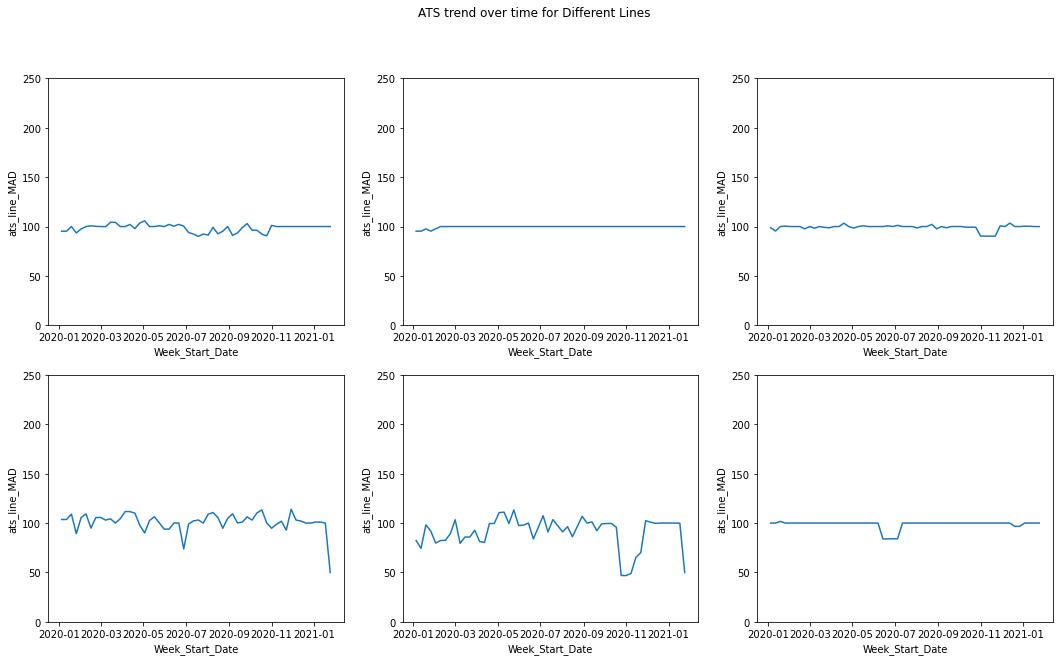

In [29]:
# Trend smoothening
line_level_prodn = line_level_prodn.groupby(['line']).apply(mad_outlier_treatment,'ats_line').reset_index(drop=True)
line_level_prodn = line_level_prodn.groupby(['line']).apply(iqr_outlier_treatment,'ats_line').reset_index(drop=True)

# Line chart ATS
prodn_line = line_level_prodn.groupby(['line'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ATS trend over time for Different Lines')

i=0; j=0
for grain in line_level_prodn.line.unique()[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_line.get_group(grain), x="Week_Start_Date", y="ats_line_MAD")
    ax.set(ylim=(0, 250))
    j+=1; 
    if j > 2:j=0;i=1


In [30]:
#3. Time series prediction

# 6MA time series prediction
holdout_date = cortex_ip['Date'].iloc[0]
train = line_level_prodn[line_level_prodn['Week_Start_Date'] <= holdout_date]
test = line_level_prodn[line_level_prodn['Week_Start_Date'] > holdout_date]

futurePeriods =  pd.date_range(start = cortex_ip['Date'].iloc[0] + timedelta(days=7), 
                               end = cortex_ip['Date'].iloc[1], freq='W').to_list()
predn = []

for name,group in train.groupby(['line']):
    data = list(group['ats_line_MAD'])
    # fit model
    model = ARIMA(data, order=(0, 0, 6))
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(len(data), len(data)+len(futurePeriods) - 1)

    predn.append(pd.DataFrame({'line':name,
                               'Week_Start_Date':futurePeriods,
                               'Time_series_outcome':yhat}))
    
line_ts_predn = pd.concat(predn).reset_index(drop=True)

accuracy_frame_line = accuracy_frame_line.merge(line_ts_predn,on=['line','Week_Start_Date'])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarnin

In [31]:
accuracy_frame_line = accuracy_frame_line[['line','Week_Start_Date','Most_Probable_Outcome','linregress_outcome','Time_series_outcome']]
accuracy_frame_line.columns = ['line','Week_Start_Date','Most_Probable_Outcome_line','linregress_outcome_line','Time_series_outcome_line']
accuracy_frame_line.head()

line Week_Start_Date  Most_Probable_Outcome_line  \
0  BBN L1 MWCR      2020-12-06                    100.2002   
1  BBN L1 MWCR      2020-12-13                    100.2002   
2  BBN L1 MWCR      2020-12-20                    100.2002   
3  BBN L1 MWCR      2020-12-27                    100.2002   
4  BBN L1 MWCR      2021-01-03                    100.2002   

   linregress_outcome_line  Time_series_outcome_line  
0                      NaN                 99.930113  
1                      NaN                 99.463487  
2                      NaN                 99.677722  
3                      NaN                 98.401040  
4                      NaN                 98.658590

In [54]:
accuracy_frame = accuracy_frame.merge(accuracy_frame_line,on=['line','Week_Start_Date'])

In [55]:
accuracy_frame_line_tmp = accuracy_frame[['dfu','location','line','Week_Start_Date','ats_capped','mars_outcome','Most_Probable_Outcome_line','linregress_outcome_line','Time_series_outcome_line']]

accuracy_frame_line_tmp['dfu_mars_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['mars_outcome'])
accuracy_frame_line_tmp['line_mle_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['Most_Probable_Outcome_line'])
accuracy_frame_line_tmp['line_linreg_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['linregress_outcome_line'])
accuracy_frame_line_tmp['line_ts_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['Time_series_outcome_line'])

best_method_selection = accuracy_frame_line_tmp.groupby(['dfu','location']).agg(dfu_mars_error = ('dfu_mars_error','mean'),                                                                       
                                                                       line_mle_error = ('line_mle_error','mean'),
                                                                       line_linreg_error = ('line_linreg_error','mean'),
                                                                       line_ts_error = ('line_ts_error','mean'))

c = ['dfu_mars_error','line_mle_error','line_linreg_error','line_ts_error']
best_method_selection = best_method_selection[c]

best_method_selection.loc[:,c] = np.round(best_method_selection[c],2)
best_method_selection = best_method_selection.assign(Min_val = best_method_selection[c].min(axis=1), Min_col=best_method_selection[c].idxmin(axis=1))

fig=plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x="Min_col", data=best_method_selection)


<ipython-input-55-9e22613190ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_frame_line_tmp['dfu_mars_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['mars_outcome'])
<ipython-input-55-9e22613190ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_frame_line_tmp['line_mle_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['Most_Probable_Outcome_line'])
<ipython-input-55-9e22613190ce>:5: SettingWithCopyWarning: 
A value is trying 

<AxesSubplot:xlabel='Min_col', ylabel='count'>

In [57]:
#best_method_selection.to_csv(os.path.join(data_path,job_id,'exp','line_ml_model_results.csv'))

## Compare all the methods

In [38]:
accuracy_frame.head()

dfu location        line Week_Start_Date  scheduled_production_in_ea  \
0  104383     FR08  HAG CRISPY      2020-11-22                12142.000000   
1  357864     FR08  HAG CRISPY      2020-11-22                 4554.166667   
2  398030     FR08  HAG CRISPY      2020-11-22                 4546.250000   
3  398032     FR08  HAG CRISPY      2020-11-22                 4192.500000   
4  104383     FR08  HAG CRISPY      2020-11-29                 8095.000000   

   ats_capped  Most_Probable_Outcome  level_2     slope   intercept  \
0  116.809422               80.18018        0  0.000002   99.425765   
1  120.000000              100.20020        0  0.000544   97.479826   
2   80.000000               99.79980        0 -0.000066  100.346069   
3  120.000000              100.20020        0  0.000574   97.133520   
4   80.000000               80.18018        0  0.000002   99.425765   

   linregress_outcome  mars_outcome  Time_series_outcome  \
0           99.449388           100            98.391572   
1           99.955441           100           104.195315   
2          100.047980           100           113.795911   
3           99.541499           100            93.515734   
4           99.441514           100            96.080508   

   Most_Probable_Outcome_line  linregress_outcome_line  \
0                    100.2002               100.129437   
1                    100.2002               100.129437   
2                    100.2002               100.129437   
3                    100.2002               100.129437   
4                    100.2002                99.975914   

   Time_series_outcome_line  
0                 95.936516  
1                 95.936516  
2                 95.936516  
3                 95.936516  
4                 94.222687

<AxesSubplot:xlabel='Min_col', ylabel='count'>

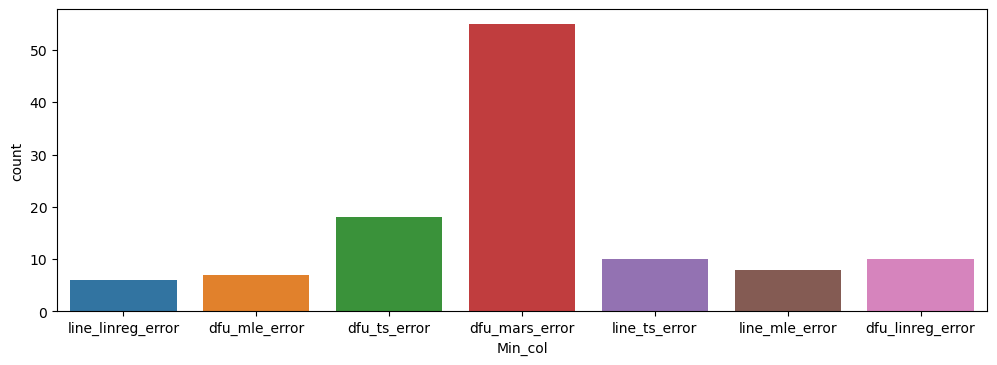

In [42]:
accuracy_frame['dfu_mle_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['Most_Probable_Outcome'])
accuracy_frame['dfu_linreg_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['linregress_outcome'])
accuracy_frame['dfu_mars_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['mars_outcome'])
accuracy_frame['dfu_ts_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['Time_series_outcome'])

accuracy_frame['line_mle_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['Most_Probable_Outcome_line'])
accuracy_frame['line_linreg_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['linregress_outcome_line'])
accuracy_frame['line_ts_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['Time_series_outcome_line'])


best_method_selection = accuracy_frame.groupby(['dfu','location']).agg(dfu_mars_error = ('dfu_mars_error','mean'),
                                                                       dfu_mle_error = ('dfu_mle_error','mean'),
                                                                       dfu_linreg_error = ('dfu_linreg_error','mean'),
                                                                       dfu_ts_error = ('dfu_ts_error','mean'),
                                                                       line_mle_error = ('line_mle_error','mean'),
                                                                       line_linreg_error = ('line_linreg_error','mean'),
                                                                       line_ts_error = ('line_ts_error','mean'))

c = ['line_mle_error','line_linreg_error','line_ts_error','dfu_ts_error','dfu_linreg_error','dfu_mle_error','dfu_mars_error']
best_method_selection = best_method_selection[c]

best_method_selection.loc[:,c] = np.round(best_method_selection[c],2)
best_method_selection = best_method_selection.assign(Min_val = best_method_selection[c].min(axis=1), Min_col=best_method_selection[c].idxmin(axis=1))

fig=plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x="Min_col", data=best_method_selection)
